In [10]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import linregress
import scipy.io
matplotlib.rcParams['text.usetex'] = True

# Functions

## 2D Animations 

In [11]:
class AnimatedScatter():

    def __init__(self,data,R):
        self.data=data

        self.fig, self.ax = plt.subplots(figsize=(8,8))
        
        x=[]
        y=[]
        self.scat = self.ax.scatter(x, y,s=1)
        self.ax.axis([-1.1*R,1.1*R,-1.1*R,1.1*R])
        self.ax.set_xlabel('x-position  [$m$]',fontsize=24)
        self.ax.set_ylabel('y-position  [$m$]',fontsize=24)
        self.ax.tick_params(axis='x',labelsize=24)
        self.ax.tick_params(axis='y',labelsize=24)


        self.ani = animation.FuncAnimation(self.fig, self.update, interval=25,frames=len(data),repeat=True)
        

    def update(self, i):
        
        x=self.data[i][:,0]
        y=self.data[i][:,1]
        
        self.scat.set_offsets(np.c_[x,y])


## Initial Distributions

In [12]:
#Initial distribution of velocities in 2D (Gaussian with variances sx,sy) and initial positions uniformly distributed in
#a circle of radius r. Initial states in the 4-state system are also assigned.
def initial(n,r,sx,sy,e):
    vx0=np.random.randn(n)*sx
    vy0=np.random.randn(n)*sy
    phi=np.random.rand(n)*2*np.pi
    R=np.sqrt(np.random.rand(n))*r
    x0=np.multiply(R,np.cos(phi))
    y0=np.multiply(R,np.sin(phi))
    state=np.zeros(n)
    r1_ind=np.random.choice(n, round(n*e/2), replace=False)
    rem=[i for i in range(n) if i not in r1_ind]
    r2_ind=np.random.choice(rem,round(n*(1-e)/2),replace=False)
    rem=[i for i in rem if i not in r2_ind]
    r3_ind=np.random.choice(rem,round(n*e/2),replace=False)
    state[r1_ind]=int(1)
    state[r2_ind]=int(2)
    state[r3_ind]=int(3)
    V=np.array([x0,y0,vx0,vy0,state])
    return V.T

#Initial distribution of velocities in 1D (Gaussian with variance sx). Initial states in the 4-state system are also assigned.
def vels_initial1D(n,sx,e):
    vx0=np.random.randn(n)*sx
    state=np.zeros(n)
    r1_ind=np.random.choice(n, int(round(n*e/2)), replace=False)
    rem=[i for i in range(n) if i not in r1_ind]
    r2_ind=np.random.choice(rem,int(round(n*(1-e)/2)),replace=False)
    rem=[i for i in rem if i not in r2_ind]
    r3_ind=np.random.choice(rem,int(round(n*e/2)),replace=False)
    state[r1_ind]=int(1)
    state[r2_ind]=int(2)
    state[r3_ind]=int(3)
    V=np.array([vx0,state])
    return V.T

## Plotting

In [13]:
#Plots spatial distribution of a sample taken randomly from the population
def plot_sample(vec,ssize):
    N=vec.shape[1]
    if N>ssize:
        inds=list(np.random.choice(np.arange(N),size=ssize))
        points=vec[inds,0:2]
    else:
        points=vec[:,0:2]

    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(111)
    ax.scatter(points[:,0],points[:,1])
    mxx=max(abs(points[:,0]))
    mxy=max(abs(points[:,1]))
#     plt.xlim((-2*mxx,2*mxx))
#     plt.ylim((-2*mxy,2*mxy))
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    plt.show()

#Eliminates outliers (for plotting only), plots velocity distribution (histogram) and a Gaussian distribution with
#temperature related to sample's variance. Acts on chosen dimension.
def plot_vel_distr(vec,axis,T_fac):
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    N=len(vec[:,0])
    if N>75:
        N=75
    inds=np.sqrt(vec[:,2]**2+vec[:,3]**2)<=5*np.std(np.sqrt(vec[:,2]**2+vec[:,3]**2))
    
    n,bins,patches=ax.hist(vec[inds,axis+2],bins=N,density=True)
    T=np.std(vec[inds,axis+2])
    T_act=T_fac*T**2
    ax.plot(bins,1/np.sqrt(2*np.pi*T**2)*np.exp(-bins**2/(2*T**2)),label='T=%.6f K'%T_act)
    
    ax.set_xlabel('Velocity [$m/s$]',fontsize=24)
    ax.tick_params(axis='x',labelsize=24)
    ax.tick_params(axis='y',labelsize=24)
        
    plt.legend(loc=1,fontsize=18)
    plt.show()
    
#Eliminates outliers (for plotting only), plots velocity distribution (histogram) and a Gaussian distribution with
#temperature related to sample's variance. Assumes 1D simulation is in use.
def plot_vel_distr1D(vels,T_fac):
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    N=len(vels)
    if N>100:
        N=100
    inds=np.sqrt(vels**2)<=5*np.std(vels)
    
    n,bins,patches=ax.hist(vels[inds],bins=N,density=True)
    
    def gauss_fun(x,T):
        return 1/np.sqrt(2*np.pi*T)*np.exp(-x**2/(2*T))
    
    bins=bins[:-1]
    popt,pcov=curve_fit(gauss_fun,bins,n)
    T=popt[0]
    T_act=T_fac*popt[0]
    
    ax.plot(bins,gauss_fun(bins,*popt),label='T=%.6f K'%T_act)
    
    ax.set_xlabel('Velocity [$m/s$]',fontsize=24)
    ax.tick_params(axis='x',labelsize=24)
    ax.tick_params(axis='y',labelsize=24)
        
    plt.legend(loc=1,fontsize=18)
    plt.show()
    
#Eliminates outliers (for plotting only), plots speed distribution (histogram) and a Maxwell-Boltzmann distribution for 2D
#with temperature found through fitting to the distribution function.
def plot_spd_distr(vec,T_fac):
    
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    N=len(vec[:,0])
    if N>75:
        N=75
    inds=np.sqrt(vec[:,2]**2+vec[:,3]**2)<=5*np.std(np.sqrt(vec[:,2]**2+vec[:,3]**2))

    n,bins,patches=ax.hist(np.sqrt(vec[inds,2]**2+vec[inds,3]**2),bins=N,density=True)
    
    def B_fun(x,T):
        return 2*np.pi*x/(2*np.pi*T)*np.exp(-x**2/(2*T))

    bins=bins[:-1]
    popt,pcov=curve_fit(B_fun,bins,n)
    T=T_fac*popt[0]
    ax.plot(bins,B_fun(bins,*popt),label='T=%.6f K'%T)
    
    ax.set_xlabel('Velocity [$m/s$]',fontsize=24)
    ax.tick_params(axis='x',labelsize=24)
    ax.tick_params(axis='y',labelsize=24)
    
    plt.legend(loc=1,fontsize=18)
    plt.show()
    

## Functions describing the dynamics

In [14]:
#2D dynamics
def push(vec,t_step,inter_function,mass,F_r):
    forces_X=F_r*inter_function(vec[:,2])
    forces_Y=F_r*inter_function(vec[:,3])
    forces=np.array([forces_X,forces_Y])
    forces=forces.T
    vec[:,0:2]=vec[:,0:2]+vec[:,2:4]*t_step+forces*t_step**2/(2*mass)
    vec[:,2:4]=vec[:,2:4]+forces*t_step/mass
    
#1D velocity change for a full vector
def vel_push1D(vels,t_step,inter_function,mass,F_r):
    forces=np.array(F_r*inter_function(vels[:,0]))
    vels[:,0]=vels[:,0]+forces*t_step/mass
    
#1D velocity change for a single particle
def vel_push(vel,t_step,inter_function,mass,F_r):
    force=F_r*inter_function(vel[0])
    vel[0]=vel[0]+force*t_step/mass
    
#2D dynamics without any forces
def expand(vec,t_step):
    vec[:,0:2]=vec[:,0:2]+vec[:,2:4]*t_step
    
#Function determining how many particles in each of the 4 states underwent a spontaneous decay in time t_s. The number of decays
#has a Poisson distribution with ratw relate to the spontaneous emission rate and the factor "eps".
def decayed(vec,eps,rate,t_s):
    
    G0=[i for i in range(len(vec[:,-1])) if vec[i,-1]==0]
    G1=[i for i in range(len(vec[:,-1])) if vec[i,-1]==1]
    G2=[i for i in range(len(vec[:,-1])) if vec[i,-1]==2]
    G3=[i for i in range(len(vec[:,-1])) if vec[i,-1]==3]
    
    N0=len(G0)
    N1=len(G1)
    N2=len(G2)
    N3=len(G3)
    
    ex0=np.random.poisson(lam=N0*eps*rate*t_s)
    ex1=np.random.poisson(lam=N1*(1-eps)*rate*t_s)
    ex2=np.random.poisson(lam=N2*eps*rate*t_s)
    ex3=np.random.poisson(lam=N3*(1-eps)*rate*t_s)
    
    
    if G0:
        C0=np.random.choice(G0,size=ex0)
    else:
        C0=[]
    if G1:
        C1=np.random.choice(G1,size=ex1)
    else:
        C1=[]
    if G2:
        C2=np.random.choice(G2,size=ex2)
    else:
        C2=[]
    if G3:
        C3=np.random.choice(G3,size=ex3)
    else:
        C3=[]

    return C0,C1,C2,C3


#Function determining to which state the particles that underwent the spontaneous decay went. Probabilities are determined by
#branching ratios and the parameter "eps". Here, branching ratios for a specific level structure in BaH has been used.
def change_cycle(vec,C0,C1,C2,C3,eps):

    if len(C0)>0:
        x=np.random.random(len(C0))
        for i in range(len(C0)):
            if x[i]<2/3:
                vec[C0[i],-1]=1
            elif x[i]<(2/3+eps/3):
                vec[C0[i],-1]=3
            else:
                vec[C0[i],-1]=2
                    
    if len(C1)>0:
        x=np.random.random(len(C1))
        for i in range(len(C1)):
            if x[i]<2/3:
                vec[C1[i],-1]=0
            elif x[i]<(2/3+eps/3):
                vec[C1[i],-1]=3
            else:
                vec[C1[i],-1]=2
    
    if len(C2)>0:
        x=np.random.random(len(C2))
        for i in range(len(C2)):
            if x[i]<2/3:
                vec[C2[i],-1]=3
            elif x[i]<(2/3+eps/3):
                vec[C2[i],-1]=1
            else:
                vec[C2[i],-1]=0
                
    if len(C3)>0:
        x=np.random.random(len(C3))
        for i in range(len(C3)):
            if x[i]<2/3:
                vec[C3[i],-1]=2
            elif x[i]<(2/3+eps/3):
                vec[C3[i],-1]=1
            else:
                vec[C3[i],-1]=0
    
#Analogical functions, but for a model with 2 state instead of 4
def decayed_twostate(vec,eps,rate,t_s):
    
    G0=[i for i in range(len(vec[:,4])) if vec[i,4]==0]
    G1=[i for i in range(len(vec[:,4])) if vec[i,4]==1]
    
    N0=len(G0)
    N1=len(G1)

    
    ex0=np.random.poisson(lam=N0*eps*rate*t_s)
    ex1=np.random.poisson(lam=N1*(1-eps)*rate*t_s)

    
    
    if G0:
        C0=np.random.choice(G0,size=ex0)
    else:
        C0=[]
    if G1:
        C1=np.random.choice(G1,size=ex1)
    else:
        C1=[]


    return C0,C1

def change_cycle_twostate(vec,C0,C1):

    if len(C0)>0:
        for i in range(len(C0)):
            vec[C0[i],4]=1
                    
    if len(C1)>0:
        for i in range(len(C1)):
            vec[C1[i],4]=0
    
#Momentum change due to spontaneous decay
def random_kick(vec,inds,mass,k,v_fac):
    an=2*np.pi*np.random.rand(len(inds))
    vec[inds,2]+=(np.cos(an)*1.0546*10**(-34)*k/mass)
    vec[inds,3]+=(np.sin(an)*1.0546*10**(-34)*k/mass)

#1D Momentum change due to spontaneous decay 
def random_kick1D(vec,inds,mass,k):
    an=2*np.pi*np.random.rand(len(inds))
    vec[inds,0]+=(np.cos(an)*1.0546*10**(-34)*k/mass)

## Additional functions

In [15]:
def eliminate_outliers(vec):
    aux=sorted(abs(vec[:,2]))
    T=aux[:,int(0.98*len(aux))]
#     T=np.std(vec[2][:])
    inds=[]
    for i in range(len(vec[:,0])):
        if abs(vec[i,2])>T or abs(vec[i,3])>T:
            inds.append(i)
    return np.delete(vec,inds,1)


#Function obtaining temperature for both dimensions separately from sample's velocity variance, and overal temperature from
#fitting the speed distribution to Maxwell-Boltzmann distribution function. Returns all three.
def get_temperature(vec,T_fac,R0):
    inds=(np.sqrt(vec[:,0]**2+vec[:,1]**2)<=1.2*R0) & (np.sqrt(vec[:,2]**2+vec[:,3]**2)<=6*np.std(np.sqrt(vec[:,2]**2+vec[:,3]**2)))
    Tx,Ty=np.std(vec[inds,2]),np.std(vec[inds,3])
    Tx,Ty=T_fac*Tx**2,T_fac*Ty**2
    N=len(vec[inds,0])
    if N>100:
        N=100
    
    n,bins=np.histogram(np.sqrt(vec[inds,2]**2+vec[inds,3]**2),bins=N,density=True)
    
    def B_fun(x,T):
        return 2*np.pi*x/(2*np.pi*T)*np.exp(-x**2/(2*T))

    bins=bins[:-1]
    popt,pcov=curve_fit(B_fun,bins,n)
    T=T_fac*popt[0]
    
    return Tx,Ty,T

#Temperature obtained from sample's velocity variance
def get_temperature1D(vels,T_fac):
    inds=np.sqrt(vels[:]**2)<=5*np.std(vels[:])
    Tx=T_fac*np.var(vels[inds])
    return Tx

#Temperature obtained from fitting
def get_temperature1D_fit(vels,T_fac):
    inds=np.sqrt(vels[:]**2)<=5*np.std(vels[:])
    N=len(inds)
    if N>100:
        N=100
    n,bins,patches=ax.hist(vels[inds],bins=N,density=True)
    
    def gauss_fun(x,T):
        return 1/np.sqrt(2*np.pi*T)*np.exp(-x**2/(2*T))
    
    bins=bins[:-1]
    popt,pcov=curve_fit(gauss_fun,bins,n)
    T=popt[0]
    T_act=T_fac*popt[0]
    
    return T_act

#This function takes veloctity vector and corresponding forces, creates and returns an interpolating function.
def initiate_interp(Vs,force_profile):
    f=interp1d(Vs,force_profile,kind="cubic")
    return f

def gaussian(X,u,s):
    return 1/np.sqrt(2*np.pi*s)*np.exp(-(X-u)**2/(2*s))

#Moving average
def MA(data,n):
    return np.convolve(np.ones((n,))/n,data,mode="same")

# Physical constants

In [16]:
M=0.138905/(6.02214077*10**(23)) #[kg] for BaH
Gamma=2*np.pi*1.12*10**6 #[Hz] for BaH APi state
k=2*np.pi/(1060.7868*10**(-9)) #[1/m] for BaH XSigma <-> APi transition
hbar=1.0545718*10**(-34) #[Js]
kB=1.38064852*10**(-23) #[J/K]
v_factor=Gamma/k #[m/s] for BaH
T_factor=M/kB #for BaH
F_rad=hbar*k*Gamma/2 #[N] for BaH

# Force profiles

In [30]:
#Load the force
BCF_force=scipy.io.loadmat('BCF_force_velocity_chi45_omega122.mat')
BCF_force=BCF_force['Force']

#Rescaling
BCF_force=BCF_force[0]*2

Delta=15 #Shift
step=0.2 #Velocity step size 
vel_lim=50 #Max velocity used in BCF profile


#Velocities originally used for the BCF profile +/- Shift
Vels_left=np.arange(-vel_lim,vel_lim+step,step)-Delta
Vels_right=np.arange(-vel_lim,vel_lim+step,step)+Delta

#Smoothing BCF profile
BCF_MA=MA(BCF_force,19)

#Extension of the force profile to higher velocities to account for dynamics of the outliers
BCF_left=np.concatenate((np.zeros(5),BCF_MA,np.zeros(5)))
BCF_right=-BCF_left #profiles are symmetric, so we don't have to reverse the left profile, just make the force opposite

#Extension of the velocities to account for dynamics of the outliers 
Vels_left=np.concatenate((np.linspace(-200,-100,5),Vels_left,np.linspace(100,200,5)))
Vels_right=np.concatenate((np.linspace(-200,-100,5),Vels_right,np.linspace(100,200,5)))

#Changing units from Gamma/k to m/s
Vels_left=Vels_left*v_factor
Vels_right=Vels_right*v_factor



#Initialization of interpolating functionse
force_left=initiate_interp(Vels_left,BCF_left)
force_right=initiate_interp(Vels_right,BCF_right)



print(force_left(0))
print(force_right(0))

103.38910909814015
-103.3891090981199


## Plots of the force profile and effective slope

-16.99138397583145


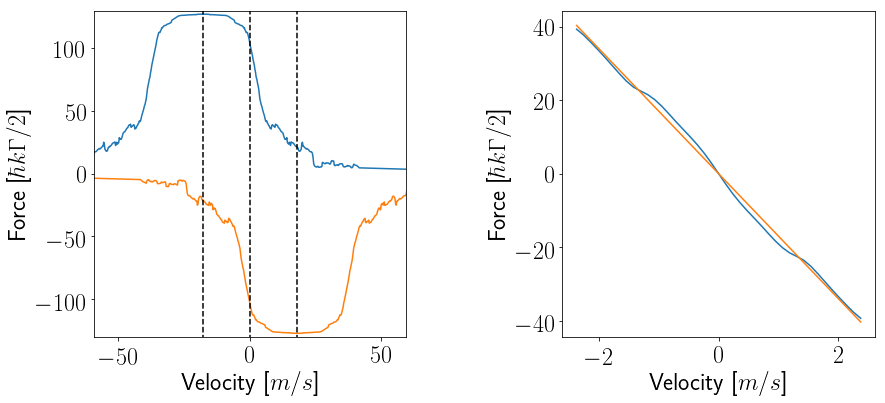

In [31]:
fig=plt.figure(figsize=(14,6))
fig.subplots_adjust(wspace=0.5)

#Force profiles
ax=fig.add_subplot(121)
ax.plot(Vels_left,BCF_left)
ax.plot(Vels_right,BCF_right)
ax.plot([0,0],[-1000,1000],"k--")
ax.plot([Delta*v_factor,Delta*v_factor],[-1000,1000],"k--")
ax.plot([-Delta*v_factor,-Delta*v_factor],[-1000,1000],"k--")
ax.set_xlim((-vel_lim*v_factor,vel_lim*v_factor))
ax.set_ylim((-130,130))
ax.set_xlabel('Velocity [$m/s$]',fontsize=24)
ax.set_ylabel('Force [$\hbar k \Gamma/2$]',fontsize=24)
ax.tick_params(axis='x',labelsize=24)
ax.tick_params(axis='y',labelsize=24)


#Velocities around v=0
V_center=np.arange(-2,2.1,0.1)*v_factor
#Effective force around v=0
Force_center=force_left(V_center)+force_right(V_center)

#linear fit
slope, intercept, r_value, p_value, std_err = linregress(V_center,Force_center)

ax2=fig.add_subplot(122)
ax2.plot(V_center,Force_center)
ax2.plot(V_center,slope*V_center+intercept)
ax2.set_xlabel('Velocity [$m/s$]',fontsize=24)
ax2.set_ylabel('Force [$\hbar k \Gamma/2$]',fontsize=24)
ax2.tick_params(axis='x',labelsize=24)
ax2.tick_params(axis='y',labelsize=24)

print(slope)

# Test of the initial distribution

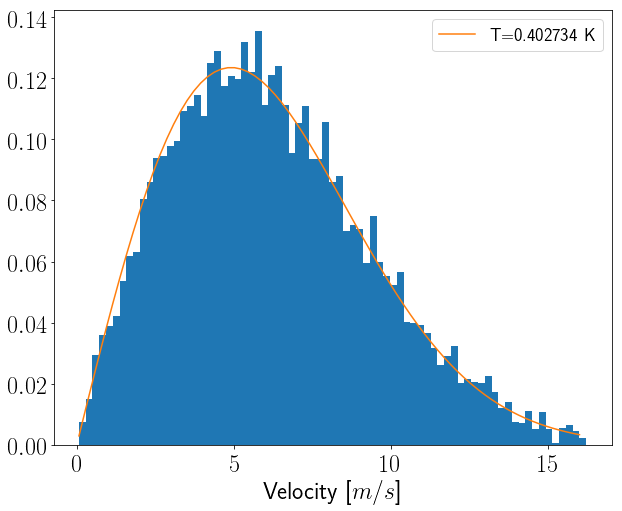

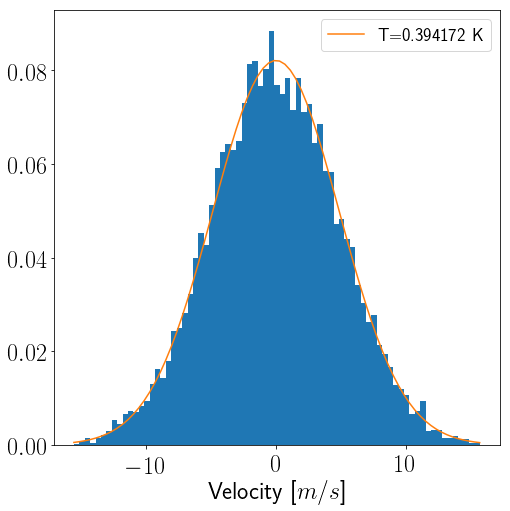

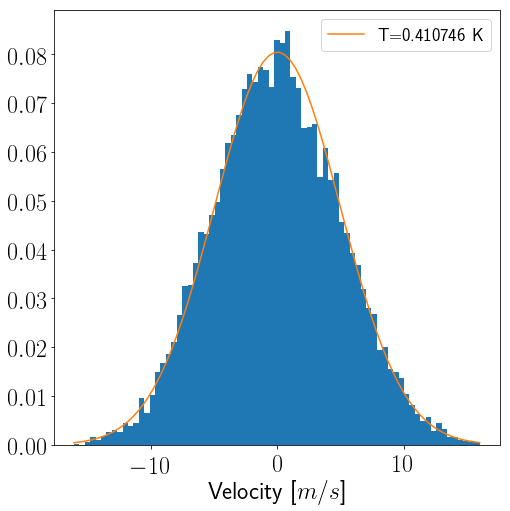

In [11]:
N_mol=10**(4)
R0=0.01 
svx=5
svy=5
eps=0.25
V=initial(N_mol,R0,svx,svy,eps)
V_in=np.copy(V)

plot_spd_distr(V,T_factor)
plot_vel_distr(V,0,T_factor)
plot_vel_distr(V,1,T_factor)

# Particle expansion simulation. No forces.

In [65]:
expansion=[] #Positions of particles at different times
expansion.append(V[:,0:2])

t_step=5*10**(-9) #[s]
t_total=10*10**(-6) #[s]
iterations=int(t_total/t_step)+1

for i in range(iterations):
    expand(V,t_step)
    
    c1,c2,c3,c4=decayed(V,eps,Gamma,t_step)
    change_cycle=(V,c1,c2,c3,c4)
    random_kick(V,np.concatenate((c1,c2,c3,c4)).astype(int),M,k,v_factor)
    
    X=V[:,0:2].copy()
    expansion.append(X)

<IPython.core.display.Javascript object>


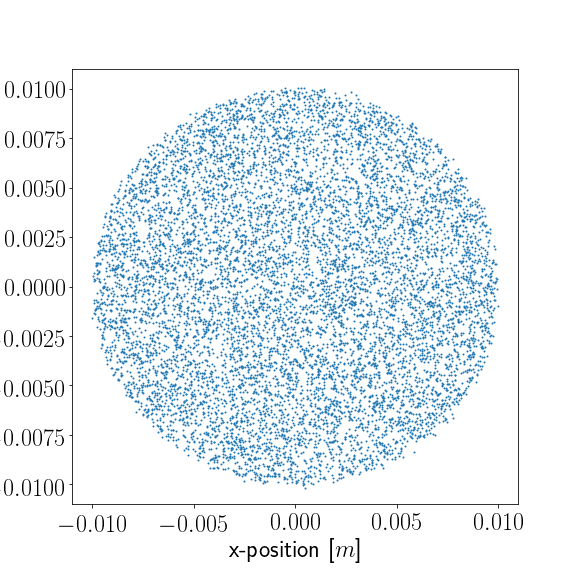

In [71]:
%matplotlib notebook
a=AnimatedScatter(expansion,R0)
plt.show()

-----------------------------

-----------------------------

# CTMC models

We can realize the continuous-time Markov chain (CTMC) model using a Monte Carlo simulation in 2 ways:
* We can molecule-by-molecule directly simulate behavior in the CTMC. In such simulation, molecule would experiance state-dependent force (given through interpolating functions) and time in a given state would have an exponential distribution that depends on the spontaneous decay rate and the "epsilon" parameter determining proportion of time spent in the excited state. Transfer to other states would be determined by the underlying Markov Chain with, in case shown here, by the branching ratios
* We can collectively affect all the molecules with state-dependent forces. After a constant time step, a certain number of molecules having a particular state would decay and transfer to one of the available states. The numebr of molecules that decayed would follow a Poisson distribution with rate related to the spontatneous decay, "epsilon" parameter, number of molecules in a state

## Collective MC simulations

### 2-level CTMC model for cooling of particles

In [85]:
#Containers for positions of molecules
force_expansion=[]

N_mol=10**(4) #Molecule number
R0=0.01 #Starting radius within which the molecules reside [m]
svx=2 #X-axis velocity standard deviation
svy=2 #Y-axis velocity standard deviation
eps=0.25 #"epsilon" parameter

t_step=5*10**(-9) #[s]
t_total=50*10**(-6) #[s]
t_record=1*10**(-6) #[s]

runs=5 #Number of runs of the simulation
iterations=int(t_total/t_step)+1 #Iterations
record_iteration=int(t_record/t_step)
record_steps=int(t_total/t_record)+1


#We want to record temperatures (in pre-chosen dimension) and all velocities for all runs, so that we can plot distributions 
#at different moments in the cooling process
T_all=np.zeros((runs,record_steps)) 
V_all=[] 


for run in range(runs):
    
    V=initial(N_mol,R0,svx,svy,eps) #Random initial distribution
    
    vels=[] #Temporary container for the velocities
    
    rec_index=0 #Index counting number of temperature recordings made
    
    #Loop with "t_step" time step 
    for i in range(iterations):
                
        #Recording of velocities, temperatures (and positions)
        if i%record_iteration==0:
            
            vs=V[:,2].copy() #Copy has to be made, in order to actually save velocities at this specific time
            vels.append(vs)
            
            try:
                Tx=get_temperature1D(V[:,2],T_factor)
                T_all[run,rec_index]=Tx
            except:
                T_all[run,rec_index]=T_all[run,rec_index-1]
                    
            #For cooling animation we only need one run saved
            if run==runs-1:
                Pos=V[:,0:2].copy()
                force_expansion.append(Pos)
                
            rec_index+=1
        
        #First, we select which molecules are in the specific states
        V0=V[np.where(V[:,4]==0)]
        V1=V[np.where(V[:,4]==1)]
        
        #Then, these molecules are acted upon by state-dependent force
        push(V0,t_step,force_left,M,F_rad)
        push(V1,t_step,force_right,M,F_rad)

        #We re-build the full vector
        V=np.concatenate((V0,V1))
        
        #Select molecules that decayed. Here, eps=1/2 - we spend half of the time on the left and on the right side of the cycle
        c1,c2=decayed_twostate(V,1/2,Gamma,t_step)
        
        #Molecuels that underwent the decay change their state
        change_cycle_twostate(V,c1,c2)
        
        #They also get a kick from photon's momentum
        random_kick(V,np.concatenate((c1,c2)).astype(int),M,k,v_factor)
        
    vs=V[:,2].copy() #Copy has to be made, in order to actually save velocities at this specific time
    vels.append(vs)
            
    try:
        Tx=get_temperature1D(V[:,2],T_factor)
        T_all[run,rec_index]=Tx
    except:
        T_all[run,rec_index]=T_all[run,rec_index-1]                   

    if run==runs-1:
        Pos=V[:,0:2].copy()
        force_expansion.append(Pos)


    V_all.append(vels)


V_all=np.array(V_all)

<IPython.core.display.Javascript object>


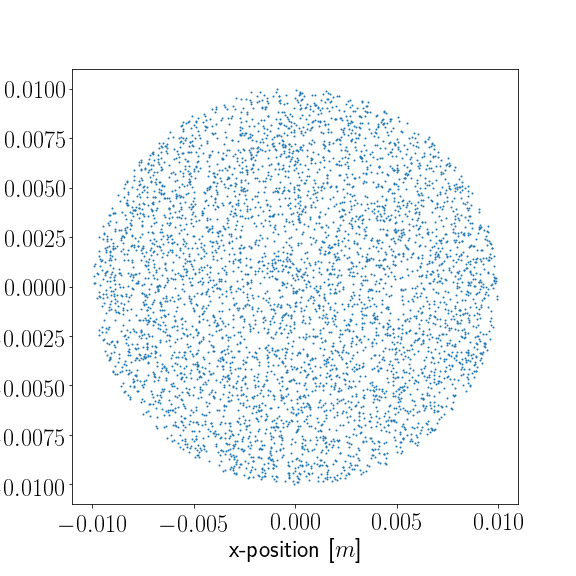

In [84]:
%matplotlib notebook
a=AnimatedScatter(force_expansion,R0)
plt.show()

### 4-level CTMC model for cooling of particles

In [88]:
#Containers for positions of molecules
force_expansion=[]

N_mol=10**(4) #Molecule number
R0=0.01 #Starting radius within which the molecules reside [m]
svx=2 #X-axis velocity standard deviation
svy=2 #Y-axis velocity standard deviation
eps=0.25 #"epsilon" parameter

t_step=5*10**(-9) #[s]
t_total=50*10**(-6) #[s]
t_record=1*10**(-6) #[s]

runs=5 #Number of runs of the simulation
iterations=int(t_total/t_step)+1 #Iterations
record_iteration=int(t_record/t_step)
record_steps=int(t_total/t_record)+1

#We want to record temperatures (in pre-chosen dimension) and all velocities for all runs, so that we can plot distributions 
#at different moments in the cooling process
T_all=np.zeros((runs,record_steps)) 
V_all=[] 

for run in range(runs):
    
    V=initial(N_mol,R0,svx,svy,eps) #Random initial distribution
    
    vels=[] #Temporary container for the velocities
    
    rec_index=0 #Index counting number of temperature recordings made
    
    #Loop with "t_step" time step 
    for i in range(iterations):
                
        #Recording of velocities, temperatures (and positions)
        if i%record_iteration==0:
            
            vs=V[:,2].copy() #Copy has to be made, in order to actually save velocities at this specific time
            vels.append(vs)
            
            try:
                Tx=get_temperature1D(V[:,2],T_factor)
                T_all[run,rec_index]=Tx
            except:
                T_all[run,rec_index]=T_all[run,rec_index-1]
                    
            #For cooling animation we only need one run saved
            if run==runs-1:
                Pos=V[:,0:2].copy()
                force_expansion.append(Pos)
                
            rec_index+=1
        
        #First, we select which molecules are in the specific states
        V0=V[np.where(V[:,4]==0)]
        V1=V[np.where(V[:,4]==1)]
        V2=V[np.where(V[:,4]==2)]
        V3=V[np.where(V[:,4]==3)]

        #Then, these molecules are acted upon by state-dependent force
        push(V0,t_step,force_left,M,F_rad)
        push(V1,t_step,force_left,M,-F_rad)
        push(V2,t_step,force_right,M,F_rad)
        push(V3,t_step,force_right,M,-F_rad)
        
        #We re-build the full vector
        V=np.concatenate((V0,V1,V2,V3))
        
        #Select molecules that decayed
        c1,c2,c3,c4=decayed(V,eps,Gamma,t_step)
        
        #Molecuels that underwent the decay change their state
        change_cycle(V,c1,c2,c3,c4,eps)
        
        #They also get a kick from photon's momentum
        random_kick(V,np.concatenate((c1,c2,c3,c4)).astype(int),M,k,v_factor)

    vs=V[:,2].copy() #Copy has to be made, in order to actually save velocities at this specific time
    vels.append(vs)
            
    try:
        Tx=get_temperature1D(V[:,2],T_factor)
        T_all[run,rec_index]=Tx
    except:
        T_all[run,rec_index]=T_all[run,rec_index-1]                   

    if run==runs-1:
        Pos=V[:,0:2].copy()
        force_expansion.append(Pos)

    V_all.append(vels)

    
V_all=np.array(V_all)

<IPython.core.display.Javascript object>


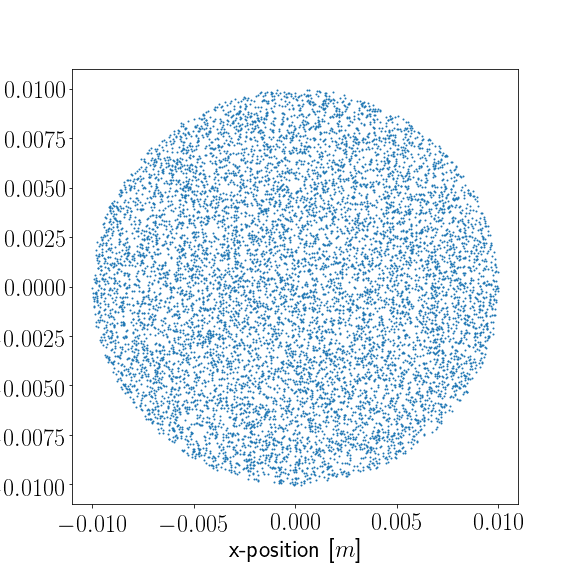

In [89]:
%matplotlib notebook
a=AnimatedScatter(force_expansion,R0)
plt.show()

### 4-level CTMC model for cooling of particles - only 1D velocities included

In [22]:
N_mol=10**(4) #Molecule number
svx=5 #X-axis velocity standard deviation
eps=0.25 #"epsilon" parameter

t_step=5*10**(-9) #[s]
t_total=200*10**(-6) #[s]
t_record=2*10**(-6) #[s]

runs=3 #Number of runs of the simulation
iterations=int(t_total/t_step)+1 #Iterations
record_iteration=int(t_record/t_step)
record_steps=int(t_total/t_record)+1

#We want to record temperatures (in pre-chosen dimension) and all velocities for all runs, so that we can plot distributions 
#at different moments in the cooling process
T_all=np.zeros((runs,record_steps)) 
V_all=[] 

for run in range(runs):
    
    V=vels_initial1D(N_mol,svx,eps) #Initial distribution
    
    vels=[] #Temporary container for the velocities
    
    rec_index=0 #Index counting number of temperature recordings made
    
    #Loop with "t_step" time step 
    for i in range(iterations):
        
        #Recording of velocities, temperatures (and positions)
        if i%record_iteration==0:
            
            vs=V[:,0].copy() #Copy has to be made, in order to actually save velocities at this specific time
            vels.append(vs)
            
            try:
                Tx=get_temperature1D_fit(V[:,0],T_factor)
                T_all[run,rec_index]=Tx
            except:
                T_all[run,rec_index]=T_all[run,rec_index-1]                    
                
            rec_index+=1
        
        #First, we select which molecules are in the specific states
        V0=V[np.where(V[:,-1]==0)]
        V1=V[np.where(V[:,-1]==1)]
        V2=V[np.where(V[:,-1]==2)]
        V3=V[np.where(V[:,-1]==3)]
        
        #Then, these molecules are acted upon by state-dependent force
        vel_push1D(V0,t_step,force_left,M,F_rad)
        vel_push1D(V1,t_step,force_left,M,-F_rad)
        vel_push1D(V2,t_step,force_right,M,F_rad)
        vel_push1D(V3,t_step,force_right,M,-F_rad)
        
        #We re-build the full vector
        V=np.concatenate((V0,V1,V2,V3))
        
        #Select molecules that decayed
        c1,c2,c3,c4=decayed(V,eps,Gamma,t_step)
        
        #Molecuels that underwent the decay change their state
        change_cycle(V,c1,c2,c3,c4,eps)
        
        #They also get a kick from photon's momentum
        random_kick1D(V,np.concatenate((c1,c2,c3,c4)).astype(int),M,k)

        
    vs=V[:,0].copy() #Copy has to be made, in order to actually save velocities at this specific time
    vels.append(vs)
            
    try:
        Tx=get_temperature1D_fit(V[:,0],T_factor)
        T_all[run,rec_index]=Tx
    except:
        T_all[run,rec_index]=T_all[run,rec_index-1]                   

    V_all.append(vels)
    print(run)

    
V_all=np.array(V_all)

0


c:\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


1
2


### Save to a file

In [19]:
with open('det20_molasses_V_high.npy', 'wb') as f:
    np.save(f, V_all)
with open('det20_molasses_T_high.npy', 'wb') as f:
    np.save(f, T_all)

### Velocity plots

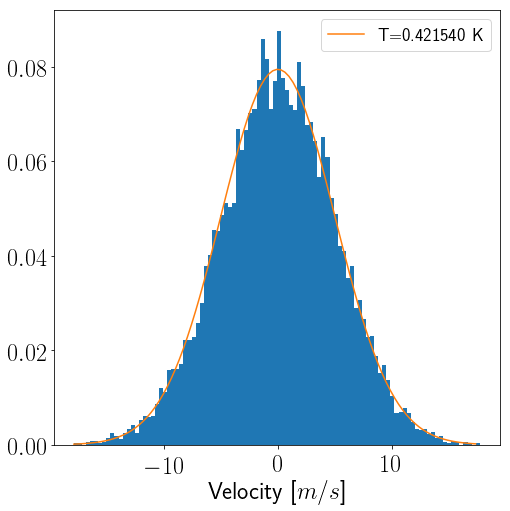

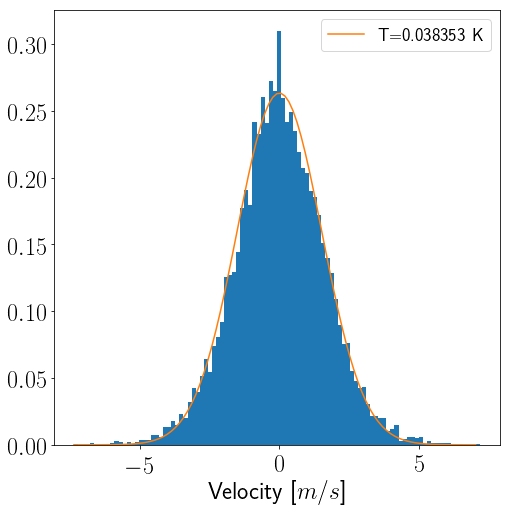

In [20]:
plot_vel_distr1D(V_all[0,0],T_factor) # t=0
plot_vel_distr1D(V_all[0,-1],T_factor) # t=t_final

### Temperature plots

T_L = 38.430 mK
tau = 16.269 us
beta = 3.832 hk2/2


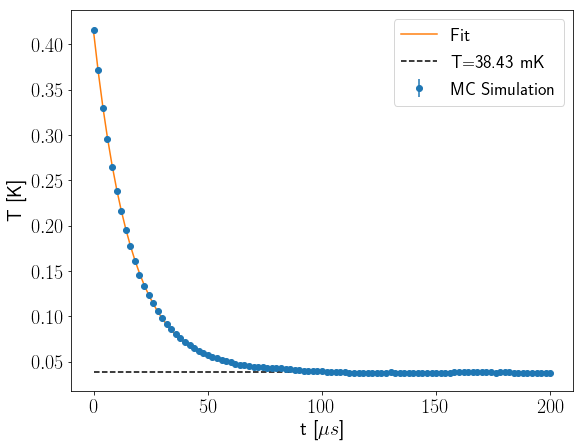

In [21]:
#With a cooling profile that's linear around v=0, i.e. F=-beta*v, we expect an exponentially decaying temperature
def T_fun(t,T_L,T_0,tau):
        return T_L+(T_0-T_L)*np.exp(-t/tau)

#We will plot means over multiple runs of a simulation
T_means=np.mean(T_all[:],axis=0)
T_errs=np.std(T_all[:],axis=0)/np.sqrt(runs)
time=np.linspace(0,t_total*10**6,record_steps)

#We fit to find the limiting temperature T_L and the tau parameter
popt,pcov=curve_fit(T_fun,time,T_means)

#From tau we can obtain effective slope
beta=M/(2*popt[2]*10**(-6))/(hbar*k**2/2)

print('T_L = {0:.3f} mK'.format(popt[0]*1000))
print('tau = {0:.3f} us'.format(popt[2]))
print('beta = {0:.3f} hk2/2'.format(beta))

fig=plt.figure(figsize=(9,7))
ax=fig.add_subplot(111)
ax.errorbar(time,T_means,yerr=T_errs,fmt='o',label="MC Simulation")
ax.plot(time,T_fun(time,*popt),label='Fit')
ax.plot(time,len(time)*[popt[0]],'k--',label="T=%.2f mK" %(popt[0]*1000))
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_ylabel('T [K]',fontsize=20)
ax.set_xlabel('t [$\mu s$]',fontsize=20)
plt.legend(loc=1,fontsize=18)

### Capture velocity plot

c:\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


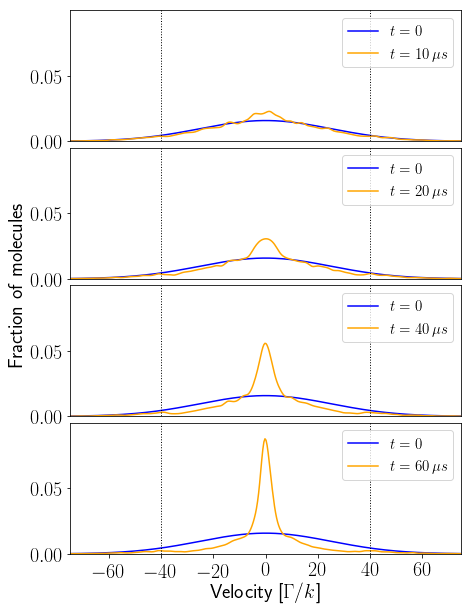

In [29]:
from scipy.interpolate import spline

V_means=np.concatenate((V_all[0,:,:],V_all[1,:,:],V_all[2,:,:]),axis=1)/v_factor


fig,ax=plt.subplots(4,1,sharey=False,sharex=True,figsize=(7,10))
fig.subplots_adjust(hspace=0.05)

inds=[5,10,20,30]


fig.text(0, 0.5, 'Fraction of molecules', va='center', rotation='vertical',fontsize=20)

for i in range(1,5):
    # ax.hist(V_means[0,:],bins=np.linspace(min(V_means[0,:]),max(V_means[0,:]),101),density=True,color='b')
    fracs,vels_e=np.histogram(V_means[inds[i-1],:],bins=np.linspace(min(V_means[0,:]),max(V_means[0,:]),101),density=True)
    T_end=T_all[0,-1]
    T_0=np.std(V_means[0,:])
    vels=np.linspace(min(V_means[0,:]),max(V_means[0,:]),501)
    T_end_act=T_end
    T_0_act=T_factor*T_0**2

    vels_e=[(vels_e[i]+vels_e[i+1])/2 for i in range(len(vels_e)-1)]

    smooth=spline(vels_e,fracs,vels)
    # print(vels_e)
    # print(len(fracs))
    # ax.plot(vels,1/np.sqrt(2*np.pi*T_0**2)*np.exp(-vels**2/(2*T_0**2)),label='t=%.2f K'% T_0_act,color='b')
    ax[i-1].plot(vels,1/np.sqrt(2*np.pi*T_0**2)*np.exp(-vels**2/(2*T_0**2)),label='$t=0$',color='b')
    # ax.plot(vels,1/np.sqrt(2*np.pi*T_end**2)*np.exp(-vels**2/(2*T_end**2)),label='T=%.2f K'% T_end_act,color='orange')
    ax[i-1].plot(vels,smooth,color='orange',label='$t=%d\,\mu s$'%((inds[i-1])*2))
    ax[i-1].plot([-40,-40],[-0.01,0.2],'k:',lw=1)
    ax[i-1].plot([40,40],[-0.01,0.2],'k:',lw=1)
    ax[i-1].set_xlim((-75,75))
    ax[i-1].set_ylim((0,0.1))
    
    
    if i==4:

        ax[i-1].set_xlabel('Velocity [$\Gamma/k$]',fontsize=20)
        ax[i-1].tick_params(axis='x',labelsize=20)
    else:
        ax[i-1].tick_params(axis='x', bottom=False)
#         ax[i-1].spines['top'].set_visible(False)
        
    
    
    ax[i-1].tick_params(axis='y',labelsize=20)
    ax[i-1].set_yticks([0,0.05])

    ax[i-1].legend(loc=1,fontsize=15)
    
# plt.show()
fig.savefig('capture_velocity_gk.pdf',dpi=300)
fig.savefig('capture_velocity_gk.png',dpi=300)

-----------------------------

## Single particle CTMC simulations

### 2-level exact CTMC - no velocity dependence of the force 

In this simulation, we initialize the molecules with different velocities, but all of them experience certain constant force. At the optimal parameters, momentum transfer of 2hbar k happens with frequency delta/pi. Here, we will use hbar k=1, delta=100 and perform the simulation for 2- and 4-color forces (eps=0.25 and eps=1/6).

In this simulation a particle moves between states until the total time accumulated becomes larger than "total_time". Time between state change event is an exponential random variable.

In [78]:
N_mol=10**4
sx=2 #Irrelevant here - the force does not depend on velocity.
total_time=5*10**4/Gamma

Eps=np.array([45/180,30/180]) #"Epsilon" factors for 2- and 4-color forces
delta=100
force=2*2*delta/np.pi

State_momentum=np.zeros((len(Eps),N_mol,2)) #Total momentum transferred in one of the states
State_time=np.zeros((len(Eps),N_mol,2)) #Total time spent in one of the states
Average_force=np.zeros((len(Eps),N_mol)) #Average force for every molecule

for j in range(len(Eps)):
    
    V=vels_initial1D(N_mol,sx,Eps[j])
    Scale_factors=[1/(Gamma*Eps[j]),1/(Gamma*(1-Eps[j]))] #Adjusted decay rates (inverted)
    
    for i in range(N_mol):
        t=total_time
        vec=V[i,:] #[Velocity,State] of a single particle

        
        while t>0:
            #If it is in state 1 (State C in the write-up)
            if vec[1]==0: 
                time_in_state=np.random.exponential(scale=Scale_factors[0]) #Wait time
                t-=time_in_state
                
                State_time[j,i,0]+=time_in_state
                State_momentum[j,i,0]+=force*time_in_state #Momentum transferred is equal to average force times the time spent
                
                vec[1]=1 #Particle can only go to state 1

            #If it is in state 1 (State W in the write-up)
            else:
                time_in_state=np.random.exponential(scale=Scale_factors[1]) #Wait time
                t-=time_in_state
                
                State_time[j,i,1]+=time_in_state
                State_momentum[j,i,1]+=-force*time_in_state #Force acts in the opposing direction (explained in the write-up)
                
                vec[1]=0 #Particle can only go to state 0

        #For every particle we want to determine an average force (so total momentum transferred / total time)
        Average_force[j,i]=sum(State_momentum[j,i,:])/total_time
        
        #Seed is sometimes changed
        if i%1000==0:
            np.random.seed()    

### Histograms

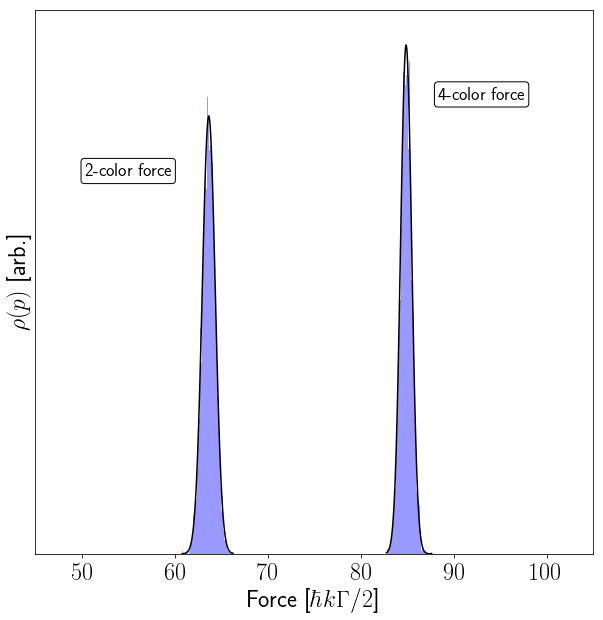

In [81]:
#Mean and variance of force distributions can be evaluate and a mathematical can be found
predicted_mean=(1-2*Eps)*force
predicted_variance=4*2*Eps*(1-Eps)*force**2/(Gamma*total_time)


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)

for i in range(len(Eps)):
    #Histogram
    n,bins,patches=ax.hist(Average_force[i,:],100, facecolor='blue', alpha=0.4,density=True)
    
    #Analytical solution
    ax.plot(bins,gaussian(bins,predicted_mean[i],predicted_variance[i]),'k-')

    
ax.set_ylabel('$\\rho(p)$ [arb.]',fontsize=24)
ax.set_xlabel('Force [$\hbar k\Gamma/2$]',fontsize=24)
ax.tick_params(axis='y',labelsize=24)
ax.tick_params(axis='x',labelsize=24)
ax.tick_params(axis='y', left=False)
ax.set_xticks([50,60,70,80,90,100])
ax.set_xlim([45,105])
ax.set_yticks([])

ax.text(55,0.5, r'2-color force',
         {'color': 'black', 'fontsize': 18, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
ax.text(93,0.6, r'4-color force',
         {'color': 'black', 'fontsize': 18, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})

fig.savefig('force_histograms_50000t.pdf',dpi=300)
fig.savefig('force_histograms_50000t.png',dpi=300)

plt.show()


### 4-level exact CTMC - no velocity dependence of the force 

In this simulation, we initialize the molecules with different velocities, but all of them experience certain constant force. At the optimal parameters, momentum transfer of 2hbar k happens with frequency delta/pi. Here, we will use hbar k=1, delta=100 and perform the simulation for 2-color forces (eps=0.25).

In this simulation a particle moves between states until the total time accumulated becomes larger than "total_time". Time between state change event is an exponential random variable.

In [82]:
N_mol=10**4
sx=2 #Irrelevant here - the force does not depend on velocity.
total_time=5*10**3/Gamma

eps=45/180 #This system, we solve only for 2-color forces
Scale_factors=[1/(Gamma*eps),1/(Gamma*(1-eps)),1/(Gamma*eps),1/(Gamma*(1-eps))]

delta=100
force=2*2*delta/np.pi

V=vels_initial1D(N_mol,sx,eps)

State_momentum=np.zeros((N_mol,4))
State_time=np.zeros((N_mol,4))
Average_force=np.zeros((N_mol,1))


for i in range(N_mol):
    
    t=total_time
    vec=V[i,:] #[Velocity,State] of a single particle

    while t>0:
        #State 0 (State C1)
        if vec[1]==0:
            time_in_state=np.random.exponential(scale=Scale_factors[0])
            t-=time_in_state
            
            State_time[i,0]+=time_in_state
            State_momentum[i,0]+=force*time_in_state
            
            #After "time_in_state" a decay occurs. It can lead to one of 3 states described in the write-up. State 0 decays to
            #State 1 with probability 2/3, to state 2 with probability (1-eps)/3 and to state 3 with probability eps/3. These
            #probabilities are true only for specific BaH system considered here.
            s=np.random.rand()
            if s<2/3:
                vec[1]=1
            elif s<(1-eps)*1/3+2/3:
                vec[1]=2
            else:
                vec[1]=3
                
        
        #State 1 (State W1)
        elif vec[1]==1:
            time_in_state=np.random.exponential(scale=Scale_factors[1])
            t-=time_in_state
            
            State_time[i,1]+=time_in_state
            State_momentum[i,1]+=-force*time_in_state
            
            
            s=np.random.rand()
            if s<2/3:
                vec[1]=0
            elif s<(1-eps)*1/3+2/3:
                vec[1]=2
            else:
                vec[1]=3
                
                
        #State 2 (State C2)
        elif vec[1]==2:
            time_in_state=np.random.exponential(scale=Scale_factors[2])
            t-=time_in_state
            
            State_time[i,2]+=time_in_state
            State_momentum[i,2]+=-force*time_in_state

            #For states 2 and 3, probability of decaying into each other is 2/3, while probability of decaying into states 
            #0 and 1 is 1/3 for both states 2 and 3.
            s=np.random.rand()
            if s<2/3:
                vec[1]=3
            elif s<(1-eps)*1/3+2/3:
                vec[1]=0
            else:
                vec[1]=1
        
        #State 3 (State W2)
        else:
            time_in_state=np.random.exponential(scale=Scale_factors[3])
            t-=time_in_state
            
            State_time[i,3]+=time_in_state
            State_momentum[i,3]+=force*time_in_state

            s=np.random.rand()
            if s<2/3:
                vec[1]=2
            elif s<(1-eps)*1/3+2/3:
                vec[1]=0
            else:
                vec[1]=1

    
    Average_force[i]=sum(State_momentum[i,:])/total_time
    
    if i%1000==0:
        np.random.seed()

### Histograms

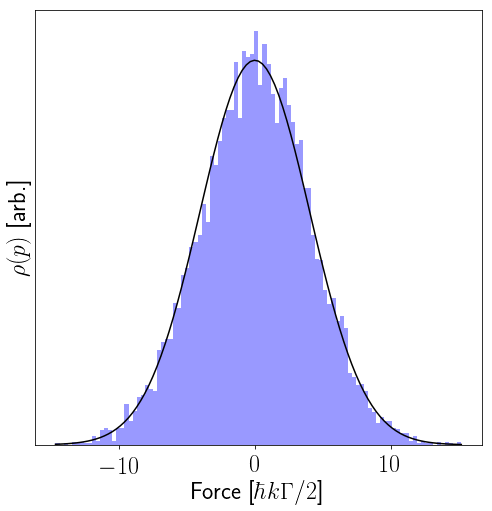

In [88]:
#Mean and variance of force distributions can be evaluate and a mathematical can be found
predicted_mean=0
predicted_variance=(force**2/(4*Gamma*total_time))*20.11 #Factor of 20.11 is found analytically for eps=1/4 (write-up)

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)

#Histogram
n,bins,patches=ax.hist(Average_force,100, facecolor='blue', alpha=0.4,density=True)
    
#Analytical solution
ax.plot(bins,gaussian(bins,predicted_mean,predicted_variance),'k-')

ax.set_ylabel('$\\rho(p)$ [arb.]',fontsize=24)
ax.set_xlabel('Force [$\hbar k\Gamma/2$]',fontsize=24)
ax.tick_params(axis='y',labelsize=24)
ax.tick_params(axis='x',labelsize=24)
ax.tick_params(axis='y', left=False)
ax.set_yticks([])


plt.show()


### 4-level CTMC model for cooling particles 

In this simulation, we initialize the molecules with different velocities, and have them experience a velocity-dependent force. Here, we will use hbar k=1, delta=100 and perform the simulation for 2-color forces using the profiles interpolated before.

In this simulation a particle moves between states until the total time accumulated becomes larger than "total_time". Time between state change event is an exponential random variable.

In [89]:
N_mol=10**4
sx=2 
total_time=5*10**3/Gamma

eps=45/180 #This system, we solve only for 2-color forces
Scale_factors=[1/(Gamma*eps),1/(Gamma*(1-eps)),1/(Gamma*eps),1/(Gamma*(1-eps))]

V=vels_initial1D(N_mol,sx,eps)

State_momentum=np.zeros((N_mol,4))
State_time=np.zeros((N_mol,4))
Average_force=np.zeros((N_mol,1))


for i in range(N_mol):
    t=total_time
    vec=V[i,:]

    while t>0:
        if vec[1]==0:
            time_in_state=np.random.exponential(scale=Scale_factors[0])
            t-=time_in_state
            State_time[i,0]+=time_in_state
            
            #We use the interpolation function to look at force for every molecule. We count in units of F_rad(=hbar k Gamma/2).
            State_momentum[i,0]+=force_left(vec[0])*time_in_state 

            vel_push(vec,time_in_state,force_left,M,F_rad) #Velocities are now changed. Force here is in units of F_rad.
            
            #State change
            s=np.random.rand()
            if s<2/3:
                vec[1]=1
            elif s<(1-eps)*1/3+2/3:
                vec[1]=2
            else:
                vec[1]=3
                
        elif vec[1]==1:
            time_in_state=np.random.exponential(scale=Scale_factors[1])
            t-=time_in_state
            State_time[i,1]+=time_in_state
            
            State_momentum[i,1]+=-force_left(vec[0])*time_in_state

            vel_push(vec,time_in_state,force_left,M,-F_rad)
            
            #State change
            s=np.random.rand()
            if s<2/3:
                vec[1]=0
            elif s<(1-eps)*1/3+2/3:
                vec[1]=2
            else:
                vec[1]=3
                
        elif vec[1]==2:
            time_in_state=np.random.exponential(scale=Scale_factors[2])
            t-=time_in_state
            State_time[i,2]+=time_in_state
            
            State_momentum[i,2]+=force_right(vec[0])*time_in_state

            vel_push(vec,time_in_state,force_right,M,F_rad)
        
            #State change
            s=np.random.rand()
            if s<2/3:
                vec[1]=3
            elif s<(1-eps)*1/3+2/3:
                vec[1]=0
            else:
                vec[1]=1
                
        else:
            time_in_state=np.random.exponential(scale=Scale_factors[3])
            t-=time_in_state
            State_time[i,3]+=time_in_state
            
            State_momentum[i,3]+=-force_right(vec[0])*time_in_state

            vel_push(vec,time_in_state,force_right,M,-F_rad)
            
            #State change
            s=np.random.rand()
            if s<2/3:
                vec[1]=2
            elif s<(1-eps)*1/3+2/3:
                vec[1]=0
            else:
                vec[1]=1

    
    Average_force[i]=sum(State_momentum[i,:])/total_time
    
    if i%1000==0:
        np.random.seed()
        
print('T_final = {0:.3f} mK'.format(get_temperature1D_fit(V[:,0],T_factor)*1000))

T_final = 35.732 mK


### Velocity plots

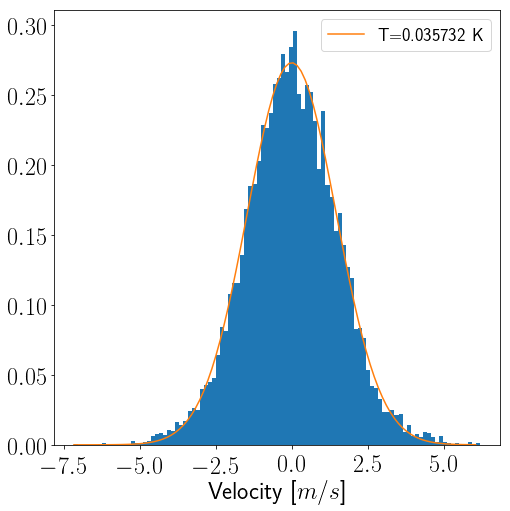

In [90]:
plot_vel_distr1D(V[:,0],T_factor) # t=t_final